## Лекция 5. Работа с изображениями в PyTorch

Нейросеть может запоминать данные, не очень понимая реальные зависимости в них. Этот процесс называется __переобучение__.

Сильно переобученная модель будет показывать очень плохие результаты на новых данных и очень хорошие результаты на тех данных, на которых она обучалась (обучающей выборке).

Для того чтобы отслеживать переобучение обычно данные разделяются на так называемые ___обучающую выборку___ и ___валидационную выборку___.

Обучающая выборка — часть данных, на которых мы будем обучать нашу нейросеть.

Валидационная выборка — часть данных, на которых мы __НИКОГДА__ не будем обучаться, но будем валидироваться (то есть будем замерять качество работы нашей модели, используя эти данные).

In [158]:
import torch
print(torch.__version__)

1.13.0+cu117


In [159]:
# Скачиваем набор данных
from torchvision import datasets

download_dir = "./dataset"

# Скачиваем обучающую выборку
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [160]:
# Объекты данных из обучающей выборки (50.000 цветных картинок размеров 32 x 32)
x_train = torch.tensor(train_data.data)
x_train.shape

torch.Size([50000, 32, 32, 3])

In [161]:
# Цели предсказания для обучающей выборки (50.000 чисел от 0 до 9)
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(9)


In [162]:
# Какому классу соответствуют цели от 0 до 9
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [163]:
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

In [164]:
# Аналогично записываем x и y для валидационной выборки (10.000 примеров)
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


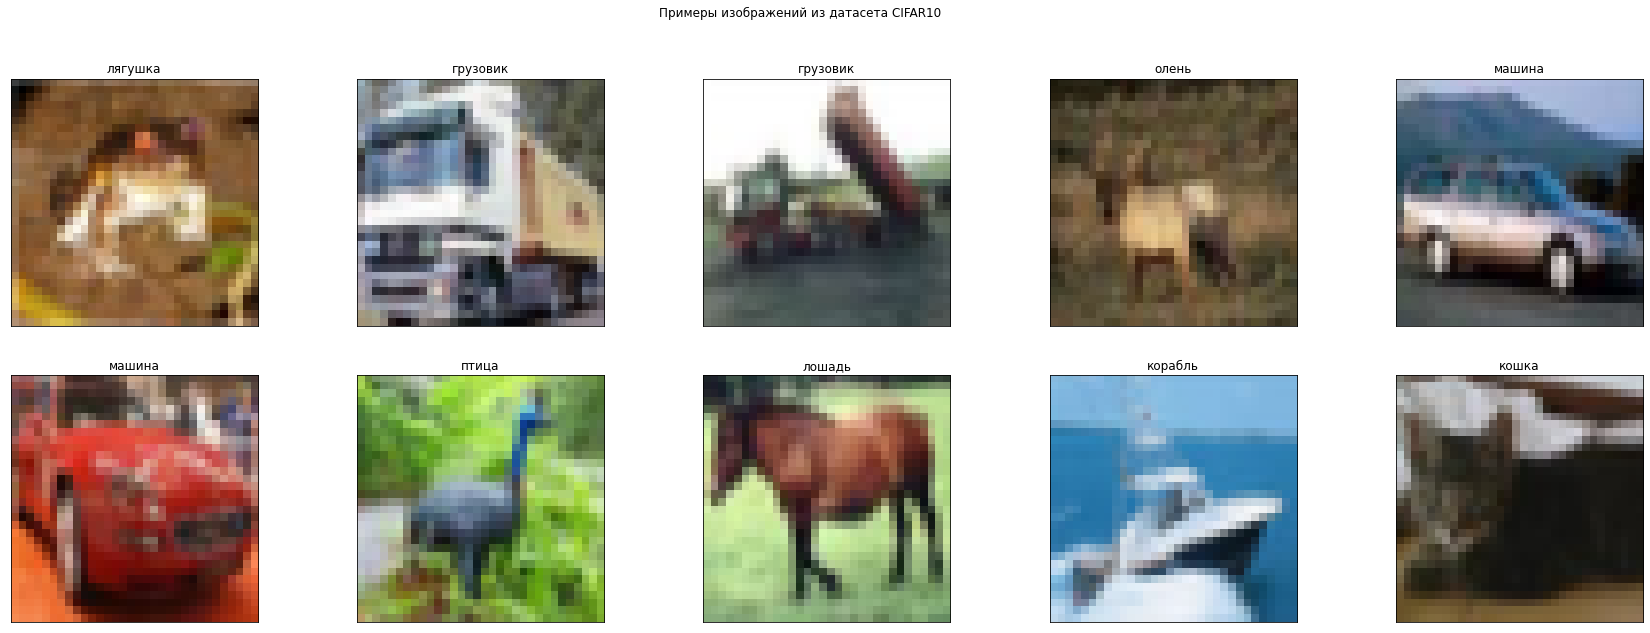

In [165]:
# Посмотрим на то как выглядят картинки из датасета

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 5 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

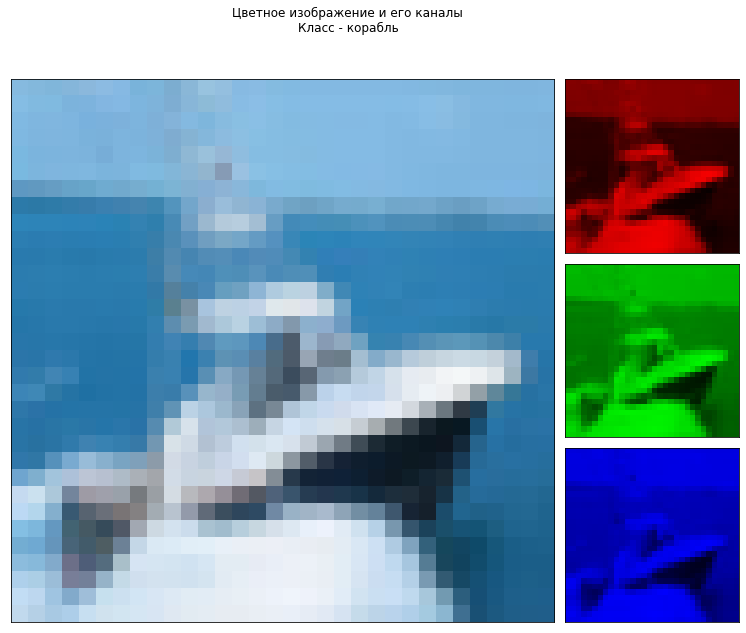

In [166]:
# Посмотрим что из себя представляют каналы изображения

from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes

obj_ind = 8

fig, ax = plt.subplots(figsize=(30, 10))
fig.suptitle(f"Цветное изображение и его каналы\nКласс - {classes_ru[y_train[obj_ind]]}")
axs_rgb = make_rgb_axes(ax, pad=0.02)

def get_rgb(img_rgb):
    h, w, _ = img_rgb.shape
    
    output = []
    for i in range(3):
        channel_image = torch.zeros((h, w, 3), dtype=torch.uint8)
        channel_image[:, :, i] = img_rgb[:, :, i]
        output.append(channel_image)
    
    return output

ax.imshow(x_train[obj_ind])
channel_images = get_rgb(x_train[obj_ind])
for i in range(3):
    axs_rgb[i].imshow(channel_images[i])
    axs_rgb[i].set_xticks([])
    axs_rgb[i].set_yticks([])
plt.show()

In [167]:
# Что из себя представляет одна картинка?
print(x_train[0].shape, x_train.min(), x_train.max(), x_train.dtype, sep="\n")

torch.Size([32, 32, 3])
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
torch.uint8


In [168]:
# Для обучения удобнее работать с вещественными числами
x_train = torch.tensor(train_data.data) / 255.
x_val = torch.tensor(val_data.data) / 255.

print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [215]:
# Свёртка
conv_layer = torch.nn.Conv2d(
    in_channels=3,  # Число каналов на входе
    out_channels=10,  # Число каналов на выходе
    kernel_size=3,  # Размер ядра
    padding=1,  # Размер паддинга (1 элемент добавляется с каждой стороны)
    padding_mode="zeros",  # Указываем что в паддинге проставляем нули вдоль границ входного тензора
    stride=1,  # Stride - 1 (смотрим на каждую позицию)
    dilation=1,  # Dilation - 1 (ядро без пропусков прикладывается к куску изображения)
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки {x.shape}")

x = conv_layer(x)

print(f"Размер после свёртки {x.shape}")

Размер до свёртки torch.Size([2, 3, 32, 32])
Размер после свёртки torch.Size([2, 10, 32, 32])


In [195]:
# Residual connection
conv_layer_2 = torch.nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    padding=1,
)

x = torch.rand(2, 10, 32, 32)

print(f"Размер до свёртки {x.shape}")

x2 = conv_layer_2(x)

print(f"Размер после свёртки {x2.shape}")

h = x + x2

Размер до свёртки torch.Size([2, 10, 32, 32])
Размер после свёртки torch.Size([2, 10, 32, 32])


In [213]:
# Residual connection если вход имеет другое количество каналов
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки {x.shape}")

x2 = conv_layer(x)

print(f"Размер после свёртки {x2.shape}")

# Вариант 1:
h = torch.cat([x, x2], 1)

print(f"Размер выхода при конкатенации {h.shape}")


# Вариант 2:
conv_1_1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=1,  # Ищем шаблоны размера 1x1xc
)
h = conv_1_1(x) + x2

print(f"Размер выхода при сумме через 1x1 свёртку {h.shape}")

Размер до свёртки torch.Size([2, 3, 32, 32])
Размер после свёртки torch.Size([2, 10, 32, 32])
Размер выхода при конкатенации torch.Size([2, 13, 32, 32])
Размер выхода при сумме через 1x1 свёртку torch.Size([2, 10, 32, 32])


In [169]:
# Напишем свой блок свёртки с residual connection

class ResidualBlock(torch.nn.Module):  # Наследуем от torch.nn.Module
    def __init__(  # Инициализация блока
        self,
        input_c,  # Число каналов на входе
        output_c,  # Число каналов на выходе
        kernel_size,  # Размер ядра
        activation=torch.nn.ReLU,  # Класс функции активации
    ):
        super().__init__()
        
        # Функция активации для нелинейности
        self.activation = activation()
        
        # Паддинг подбираем такой, чтобы размеры h и w изображения не менялись
        #  (считаем что размер ядра всегда нечётный)
        padding_size = (kernel_size - 1) // 2
        
        # Операция свёртки
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode="zeros",
        )
        
        # Если число каналов у входа и выхода различаются, то будем делать свёртку с
        #  ядром размера 1
        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход
    
    def forward(self, x):  # Прямой проход
        return self.activation(self.conv(x) + self.correct_channels(x))

In [170]:
ResidualBlock(3, 10, 3)

ResidualBlock(
  (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (correct_channels): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
  (activation): ReLU()
)

In [171]:
ResidualBlock(10, 10, 3, torch.nn.Tanh)

ResidualBlock(
  (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (correct_channels): Identity()
  (activation): Tanh()
)

In [172]:
tmp_in = torch.rand(1, 3, 20, 15)  # Изображения нужно подавать в формате Batch_size x Channels x Hight x Width

tmp_out = ResidualBlock(input_c=3, output_c=10, kernel_size=3)(tmp_in)

print(tmp_in.shape, tmp_out.shape, sep## Лекция 5. Работа с изображениями в PyTorch="\n")

torch.Size([1, 3, 20, 15])
torch.Size([1, 10, 20, 15])
